In [2]:
import os

In [5]:
dataset_path = "C:\project_ml\solar-panel-detection\dataset"
images_path = os.path.join(dataset_path, "image_chips_native")
labels_path = os.path.join(dataset_path, "labels\labels_native")

print("Sample Images:", os.listdir(images_path)[:5])
print("Sample Labels:", os.listdir(labels_path)[:5])

Sample Images: ['solarpanels_native_1__x0_0_y0_6845_dxdy_416.tif', 'solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif', 'solarpanels_native_1__x0_0_y0_7119_dxdy_416.tif', 'solarpanels_native_1__x0_0_y0_7229_dxdy_416.tif', 'solarpanels_native_1__x0_0_y0_7230_dxdy_416.tif']
Sample Labels: ['solarpanels_native_1__x0_0_y0_6845_dxdy_416.txt', 'solarpanels_native_1__x0_0_y0_6963_dxdy_416.txt', 'solarpanels_native_1__x0_0_y0_7119_dxdy_416.txt', 'solarpanels_native_1__x0_0_y0_7229_dxdy_416.txt', 'solarpanels_native_1__x0_0_y0_7230_dxdy_416.txt']


# Data Exploration and Understanding

## Dataset Statistics

In [7]:
# Compute the number of instances
total_instances = 0

for label_file in os.listdir(labels_path):
    file_path = os.path.join(labels_path, label_file)

    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines() if line.strip()]  # Remove empty lines
        total_instances += len(lines)  # Count number of annotations 

print(f"Total solar panel instances: {total_instances}")

Total solar panel instances: 29625


In [21]:
# Compute Labels Per Image Distribution
import pandas as pd

label_counts = []

for file in os.listdir(labels_path):
    with open(os.path.join(labels_path, file), 'r') as f:
        label_counts.append(sum(1 for _ in f))

df = pd.DataFrame(label_counts, columns=["Labels per Image"])
df["Labels per Image"].value_counts()

3     221
4     218
5     217
6     189
8     184
     ... 
55      1
64      1
61      1
56      1
22      1
Name: Labels per Image, Length: 74, dtype: int64

## Calculate the statistics of the area of solar panels in meters

### Formula used to compute the area of sinle instance:
$$ Area=(x_
{width}
​
 × \ chip \ width (in \ meters))×(y_ 
{width}
​
 ×\ chip \ height (in \ meters)) $$

In [24]:
# Compute Solar Panel Area Statistics
import numpy as np

pixel_to_meter = {"native": 0.31, "hd": 0.155}

areas = []

for file in os.listdir(labels_path):
    chip_size = 416 if "native" in file else 832
    scale = pixel_to_meter["native"] if "native" in file else pixel_to_meter["hd"]
    
    with open(os.path.join(labels_path, file), 'r') as f:
        for line in f:
            _, xc, yc, xw, yw = map(float, line.split())
            width_meters = xw * chip_size * scale
            height_meters = yw * chip_size * scale
            areas.append(width_meters * height_meters)

print(f"Mean Area: {np.mean(areas)} m²")
print(f"Standard Deviation: {np.std(areas)} m²")

Mean Area: 191.51782786497893 m²
Standard Deviation: 630.7003355500087 m²


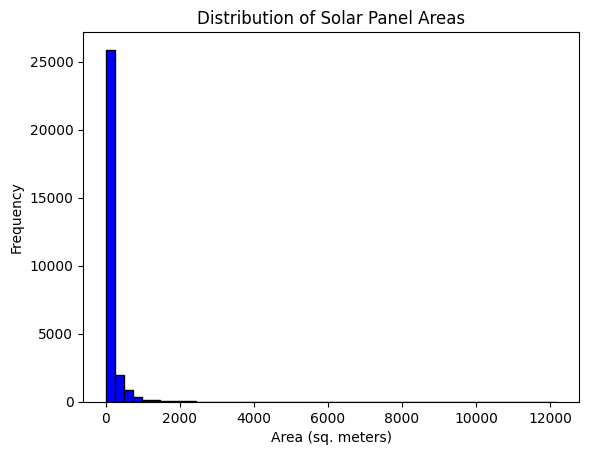

In [25]:
# Plot Histogram of Areas
import matplotlib.pyplot as plt

plt.hist(areas, bins=50, color='blue', edgecolor='black')
plt.xlabel("Area (sq. meters)")
plt.ylabel("Frequency")
plt.title("Distribution of Solar Panel Areas")
plt.show()

# Implementing the Fundamental Functions

##  Function to compute IoU 

In [52]:
# Implementing IoU Function Using Shapely Library
from shapely.geometry import box

def compute_iou(box1, box2):
    """
    Compute IoU using Shapely library.

    :param box1: (x, y, width, height) for the first bounding box
    :param box2: (x, y, width, height) for the second bounding box
    :return: Intersection over Union (IoU) score
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Create Shapely Polygon objects for the bounding boxes
    poly1 = box(x1, y1, x1 + w1, y1 + h1)
    poly2 = box(x2, y2, x2 + w2, y2 + h2)

    # Compute intersection and union areas
    intersection_area = poly1.intersection(poly2).area
    union_area = poly1.union(poly2).area

    # Compute IoU (avoid division by zero)
    iou = intersection_area / union_area if union_area > 0 else 0
    return iou

print(f"IoU: {compute_iou(box1, box2)}")

IoU: 0.21951219512195122


In [43]:
import supervision as sv
print(dir(sv))
print(dir(sv.detection))

['BaseDataset', 'BlurAnnotator', 'BoundingBoxAnnotator', 'BoxAnnotator', 'BoxCornerAnnotator', 'BoxMaskAnnotator', 'ByteTrack', 'CircleAnnotator', 'ClassificationDataset', 'Classifications', 'Color', 'ColorLookup', 'ColorPalette', 'ConfusionMatrix', 'DetectionDataset', 'Detections', 'DotAnnotator', 'EllipseAnnotator', 'FPSMonitor', 'HaloAnnotator', 'HeatMapAnnotator', 'ImageSink', 'InferenceSlicer', 'LabelAnnotator', 'LineZone', 'LineZoneAnnotator', 'MaskAnnotator', 'MeanAveragePrecision', 'Point', 'PolygonZone', 'PolygonZoneAnnotator', 'Position', 'Rect', 'TraceAnnotator', 'VideoInfo', 'VideoSink', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'annotators', 'box_iou_batch', 'classification', 'crop_image', 'dataset', 'detection', 'draw', 'draw_filled_rectangle', 'draw_image', 'draw_line', 'draw_polygon', 'draw_rectangle', 'draw_text', 'filter_polygons_by_area', 'geometry', 'get_polygon_center', 'get_

In [44]:
# Implementing IoU Function Using Supervision Library
import numpy as np
import supervision as sv

def compute_iou_sv(box1, box2):
    # Convert (x, y, width, height) -> (x_min, y_min, x_max, y_max)
    b1 = np.array([[box1[0], box1[1], box1[0] + box1[2], box1[1] + box1[3]]])
    b2 = np.array([[box2[0], box2[1], box2[0] + box2[2], box2[1] + box2[3]]])

    # Compute IoU using supervision's box_iou_batch
    iou_matrix = sv.box_iou_batch(b1, b2)

    return iou_matrix[0, 0]

print(f"IoU: {compute_iou_sv(box1, box2)}")

IoU: 0.21951219512195122


## Function to compute Average Precision (AP)  

In [46]:
# Pascal VOC 11 point interpolation method
import numpy as np

def voc_ap(recalls, precisions):
    recalls = np.insert(recalls, 0, 0)
    precisions = np.insert(precisions, 0, 0)
    
    for i in range(len(precisions) - 1, 0, -1):
        precisions[i - 1] = max(precisions[i - 1], precisions[i])
    
    indices = np.linspace(0, 1, 11)
    interpolated_precision = [np.max(precisions[np.where(recalls >= t)]) for t in indices]

    return np.mean(interpolated_precision)

print(f"VOC AP: {voc_ap(recalls, precisions)}")

VOC AP: 0.5545454545454546


In [47]:
# COCO 101-point interpolation method
import numpy as np

def coco_ap(recalls, precisions):
    recalls = np.insert(recalls, 0, 0) 
    precisions = np.insert(precisions, 0, 0)  
    
    # Make precision non-decreasing
    for i in range(len(precisions) - 1, 0, -1):
        precisions[i - 1] = max(precisions[i - 1], precisions[i])
    
    # 101-point interpolation
    recall_levels = np.linspace(0, 1, 101)  # 101 points from 0 to 1
    interpolated_precision = [np.max(precisions[recalls >= r]) if np.any(recalls >= r) else 0 for r in recall_levels]

    return np.mean(interpolated_precision)  # Mean of interpolated precision values

print(f"COCO AP: {coco_ap(recalls, precisions):.4f}")


COCO AP: 0.5416


In [50]:
#Area under Precision-Recall Curve (AP) method
import numpy as np

def vocc_ap(recalls, precisions):
   
    # Sort recalls and ensure they're monotonically increasing
    recalls = np.insert(recalls, 0, 0)  # Start from (0, 0)
    precisions = np.insert(precisions, 0, 1)  # Assume precision starts at 1

    # Ensure precision is non-decreasing for AP calculation
    for i in range(len(precisions) - 1, 0, -1):
        precisions[i - 1] = max(precisions[i - 1], precisions[i])

    # Compute AP using the trapezoidal rule
    ap = np.trapz(precisions, recalls)  # Integrates w.r.t recall values

    return ap

print(f"VOC AP (AUC PR): {voc_ap(recalls, precisions):.4f}")

VOC AP (AUC PR): 0.6200


In [54]:
num_images = 10
image_size = (100, 100)  # 100x100 pixels
box_size = (20, 20)  # 20x20 boxes

# Store results
all_ious = []
all_recalls = []
all_precisions = []

for i in range(num_images):
    # Generate 10 random GT boxes
    gt_boxes = np.random.randint(0, 80, size=(10, 2))  # (x, y) positions
    gt_boxes = np.hstack((gt_boxes, np.full((10, 2), 20)))  # (x, y, width, height)

    # Generate 10 random predicted boxes
    pred_boxes = np.random.randint(0, 80, size=(10, 2))  # (x, y) positions
    pred_boxes = np.hstack((pred_boxes, np.full((10, 2), 20)))  # (x, y, width, height)

    # Compute IoUs
    ious = np.array([compute_iou(gt, pred) for gt, pred in zip(gt_boxes, pred_boxes)])
    all_ious.append(ious)

    # Determine True Positives (TP), False Positives (FP), False Negatives (FN)
    tp = np.sum(ious >= 0.5)  # Matches with IoU ≥ 0.5
    fp = len(pred_boxes) - tp  # Predictions that did not match
    fn = len(gt_boxes) - tp  # Missed ground truths

    # Compute precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    all_recalls.append(recall)
    all_precisions.append(precision)

# Convert to NumPy arrays
recalls = np.array(all_recalls)
precisions = np.array(all_precisions)

# Compute AP50 using three methods
ap_11 = voc_ap(recalls, precisions)
ap_101 = coco_ap(recalls, precisions)
ap_auc = vocc_ap(recalls, precisions)

print(f"AP50 (VOC 11-point): {ap_11:.4f}")
print(f"AP50 (COCO 101-point): {ap_101:.4f}")
print(f"AP50 (AUC PR): {ap_auc:.4f}")


AP50 (VOC 11-point): 0.0950
AP50 (COCO 101-point): 0.0416
AP50 (AUC PR): 0.0950


# Model Building and Evaluation 

In [58]:
import shutil
import random

# Paths
images_dir = "C:\\project_ml\\solar-panel-detection\\dataset\\image_chips_native"
labels_dir = "C:\\project_ml\\solar-panel-detection\\dataset\\labels\\labels_native"
output_dir = "C:\\project_ml\\solar-panel-detection\\dataset\\split_dataset"

image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".tif")])
label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith(".txt")])

# Ensure 1:1 mapping
image_files = [f for f in image_files if f.replace(".tif", ".txt") in label_files]
label_files = [f for f in label_files if f.replace(".txt", ".tif") in image_files]  # Keep them as .txt

# Shuffle dataset
data = list(zip(image_files, label_files))
random.shuffle(data)

# Split data
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
train_split = int(len(data) * train_ratio)
val_split = int(len(data) * (train_ratio + val_ratio))

train_data = data[:train_split]
val_data = data[train_split:val_split]
test_data = data[val_split:]

# Function to copy files
def copy_files(data, dest_folder):
    os.makedirs(dest_folder, exist_ok=True)
    for img, lbl in data:
        shutil.copy(os.path.join(images_dir, img), os.path.join(dest_folder, img))  # Copy image
        shutil.copy(os.path.join(labels_dir, lbl), os.path.join(dest_folder, lbl))  # Copy label

# Copy files to output folders
copy_files(train_data, os.path.join(output_dir, "train"))
copy_files(val_data, os.path.join(output_dir, "val"))
copy_files(test_data, os.path.join(output_dir, "test"))

print("Dataset split completed successfully!")

Dataset split completed successfully!


In [70]:
import os

label_dir = "C:/project_ml/solar-panel-detection/dataset/labels/labels_native"  # Update with your label folder path

class_ids = set()

for filename in os.listdir(label_dir):
    if filename.endswith(".txt"):
        file_path = os.path.join(label_dir, filename)
        with open(file_path, "r") as file:
            lines = file.readlines()
            for line in lines:
                parts = line.split()
                if parts:
                    class_ids.add(int(parts[0]))  # Collect unique class indices

print(f"Unique class IDs found in labels: {sorted(class_ids)}")
print(f"Total detected classes: {len(class_ids)}")

Unique class IDs found in labels: [0, 1, 2]
Total detected classes: 3


In [22]:
import os

image_dir = "C:/project_ml/solar-panel-detection/dataset/image_chips_native" 
label_dir = "C:/project_ml/solar-panel-detection/dataset/labels/labels_native"

image_files = os.listdir(image_dir)
label_files = os.listdir(label_dir)

print(f" Total Images: {len(image_files)}")
print(f" Total Labels: {len(label_files)}")

 Total Images: 2553
 Total Labels: 2542


In [23]:
import os

image_dir = "C:/project_ml/solar-panel-detection/dataset/image_chips_native" 
label_dir = "C:/project_ml/solar-panel-detection/dataset/labels/labels_native"

import random

label_files = os.listdir(label_dir)
random_samples = random.sample(label_files, min(5, len(label_files)))

for file in random_samples:
    with open(os.path.join(label_dir, file), "r") as f:
        print(f"\n  {file}:\n{f.read()}")



  solarpanels_native_2__x0_5532_y0_5173_dxdy_416.txt:
0 0.3713942307692308 0.5336538461538461 0.21875 0.21634615384615385
0 0.4603365384615385 0.4447115384615385 0.18990384615384617 0.1875
0 0.4903846153846154 0.6658653846153847 0.2403846153846154 0.2451923076923077
0 0.5817307692307693 0.5793269230769231 0.20673076923076925 0.21153846153846156
0 0.686298076923077 0.6899038461538461 0.16105769230769232 0.16346153846153846
0 0.6129807692307693 0.7932692307692308 0.22115384615384617 0.21634615384615385
0 0.78125 0.9266826923076924 0.15865384615384617 0.1466346153846154
0 0.9290865384615385 0.9290865384615385 0.14182692307692307 0.14182692307692307


  solarpanels_native_2__x0_805_y0_10449_dxdy_416.txt:
0 0.6358173076923077 0.16466346153846154 0.07451923076923077 0.021634615384615384
0 0.6286057692307693 0.20192307692307693 0.14182692307692307 0.02403846153846154
0 0.6322115384615385 0.23677884615384617 0.20192307692307693 0.026442307692307696
0 0.6334134615384616 0.2692307692307693 0.27

In [103]:
import cv2
import os

image_dir = "C:/project_ml/solar-panel-detection/dataset/image_chips_native"
label_dir = "C:/project_ml/solar-panel-detection/dataset/labels/labels_native"
output_dir = "C:/project_ml/solar-panel-detection/dataset/labeled_images"

os.makedirs(output_dir, exist_ok=True)

# Include .tif extension along with .jpg and .png
image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.png', '.tif'))])
label_files = sorted(os.listdir(label_dir))

for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    # Replace image extension with .txt for label lookup (works if naming conventions match)
    label_file = image_file.rsplit(".", 1)[0] + ".txt"
    label_path = os.path.join(label_dir, label_file)

    print(f"\n🔹 Processing: {image_file}")
    
    # Check if label file exists
    if not os.path.exists(label_path):
        print(f"No label file found for {image_file}")
        continue

    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f" Could not load image {image_file}")
        continue
    
    # Read label file
    with open(label_path, "r") as f:
        lines = f.readlines()

    if not lines:
        print(f" Empty label file: {label_file}")
        continue

    # Draw bounding boxes
    h, w, _ = image.shape
    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            print(f" Incorrect label format in {label_file}: {line}")
            continue
        
        class_idx, x_center, y_center, width, height = map(float, parts)
        
        x1 = int((x_center - width / 2) * w)
        y1 = int((y_center - height / 2) * h)
        x2 = int((x_center + width / 2) * w)
        y2 = int((y_center + height / 2) * h)

        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Save the labeled image
    output_path = os.path.join(output_dir, image_file)
    cv2.imwrite(output_path, image)
    print(f" Saved labeled image: {output_path}")

print(" Script finished")


🔹 Processing: solarpanels_native_1__x0_0_y0_6845_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_0_y0_6845_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_0_y0_7119_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_0_y0_7119_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_0_y0_7229_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_0_y0_7229_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_0_y0_7230_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_0_y0_7230_dxdy_416.tif

🔹 Processing: solarpanels_native_1

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_1087_y0_6107_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_1095_y0_7782_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_1095_y0_7782_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_1099_y0_7866_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_1099_y0_7866_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_1101_y0_6503_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_1101_y0_6503_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_1102_y0_6355_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_1102_y0_6355_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_1127_y0_6206_dxdy_416.tif
✅ Sav

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_1302_y0_6506_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_13084_y0_14026_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_13084_y0_14026_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_1309_y0_8401_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_1309_y0_8401_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_13111_y0_2845_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_13111_y0_2845_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_13161_y0_13952_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_13161_y0_13952_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_13167_y0_14045_dxdy_4

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_1501_y0_10325_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_1503_y0_8830_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_1503_y0_8830_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_1506_y0_9390_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_1506_y0_9390_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_1506_y0_9727_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_1506_y0_9727_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_1511_y0_9177_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_1511_y0_9177_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_1528_y0_7291_dxdy_416.tif
✅ Sa

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_1816_y0_6688_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_1822_y0_7039_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_1822_y0_7039_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_1836_y0_9098_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_1836_y0_9098_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_1841_y0_7154_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_1841_y0_7154_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_1853_y0_7572_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_1853_y0_7572_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_1869_y0_7288_dxdy_416.tif
✅ Sav

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_2270_y0_8179_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_2282_y0_7116_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_2282_y0_7116_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_2300_y0_8080_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_2300_y0_8080_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_2309_y0_8071_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_2309_y0_8071_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_2311_y0_8124_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_2311_y0_8124_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_2344_y0_8184_dxdy_416.tif
✅ Sav

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_2837_y0_10322_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_2870_y0_10245_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_2870_y0_10245_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_2884_y0_7809_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_2884_y0_7809_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_2913_y0_9984_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_2913_y0_9984_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_2964_y0_10181_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_2964_y0_10181_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_2987_y0_7715_dxdy_416.tif


✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_3508_y0_3327_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_351_y0_8077_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_351_y0_8077_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_3527_y0_12978_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_3527_y0_12978_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_3530_y0_10812_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_3530_y0_10812_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_359_y0_8636_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_359_y0_8636_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_3625_y0_10789_dxdy_416.tif
✅ Sa

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_3888_y0_10786_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_3894_y0_13303_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_3894_y0_13303_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_3903_y0_13252_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_3903_y0_13252_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_3904_y0_11864_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_3904_y0_11864_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_3917_y0_12234_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_3917_y0_12234_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_3917_y0_13803_dxdy_416

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_4272_y0_10805_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_4286_y0_10631_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_4286_y0_10631_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_4310_y0_13077_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_4310_y0_13077_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_4316_y0_10967_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_4316_y0_10967_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_4324_y0_13169_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_4324_y0_13169_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_434_y0_8554_dxdy_416.t

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_4727_y0_13080_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_4766_y0_12968_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_4766_y0_12968_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_4773_y0_6078_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_4773_y0_6078_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_4774_y0_11627_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_4774_y0_11627_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_4777_y0_5990_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_4777_y0_5990_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_4783_y0_11309_dxdy_416.tif

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_576_y0_7213_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_5797_y0_13468_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_5797_y0_13468_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_581_y0_6899_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_581_y0_6899_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_5820_y0_13494_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_5820_y0_13494_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_5833_y0_12068_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_5833_y0_12068_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_5848_y0_13294_dxdy_416.tif
✅

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_6484_y0_12169_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_6489_y0_12706_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_6489_y0_12706_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_6496_y0_12146_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_6496_y0_12146_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_6498_y0_12420_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_6498_y0_12420_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_6503_y0_12150_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_6503_y0_12150_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_6513_y0_8680_dxdy_416.

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_6714_y0_12262_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_6717_y0_10647_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_6717_y0_10647_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_6720_y0_10987_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_6720_y0_10987_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_6723_y0_8924_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_6723_y0_8924_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_6724_y0_12292_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_6724_y0_12292_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_6729_y0_12272_dxdy_416.t

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_7021_y0_9724_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_7023_y0_11614_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_7023_y0_11614_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_7029_y0_11606_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_7029_y0_11606_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_7045_y0_9718_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_7045_y0_9718_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_7046_y0_11045_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_7046_y0_11045_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_705_y0_7531_dxdy_416.tif


✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_7604_y0_9799_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_7615_y0_8412_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_7615_y0_8412_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_7620_y0_8411_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_7620_y0_8411_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_7624_y0_12848_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_7624_y0_12848_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_762_y0_8855_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_762_y0_8855_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_7632_y0_9852_dxdy_416.tif
✅ Sav

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_7918_y0_11152_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_7926_y0_10413_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_7926_y0_10413_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_7929_y0_9710_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_7929_y0_9710_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_7934_y0_8341_dxdy_416(1).tif
🛑 No label file found for solarpanels_native_1__x0_7934_y0_8341_dxdy_416(1).tif

🔹 Processing: solarpanels_native_1__x0_7934_y0_8341_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_7934_y0_8341_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_7934_y0_8347_dxdy_416(1).tif
🛑 No label file found for solarpanels_native_1__x

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_8123_y0_8023_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_8129_y0_10391_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_8129_y0_10391_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_8135_y0_12171_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_8135_y0_12171_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_8136_y0_12903_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_8136_y0_12903_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_8141_y0_12142_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_8141_y0_12142_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_8142_y0_12149_dxdy_416.

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_8326_y0_8594_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_8327_y0_7745_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_8327_y0_7745_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_8334_y0_8417_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_8334_y0_8417_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_8335_y0_7902_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_8335_y0_7902_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_8344_y0_8586_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_8344_y0_8586_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_8350_y0_8860_dxdy_416.tif
✅ Sav

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_8570_y0_12300_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_8573_y0_11090_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_8573_y0_11090_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_857_y0_8894_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_857_y0_8894_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_8582_y0_11150_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_8582_y0_11150_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_8585_y0_10708_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_8585_y0_10708_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_8591_y0_10476_dxdy_416.tif

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_8958_y0_12045_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_8961_y0_10961_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_8961_y0_10961_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_8965_y0_12604_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_8965_y0_12604_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_8974_y0_12738_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_8974_y0_12738_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_8976_y0_11494_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_8976_y0_11494_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_8991_y0_12048_dxdy_416

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_9470_y0_298_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_9473_y0_11627_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_9473_y0_11627_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_9475_y0_10997_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_9475_y0_10997_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_9478_y0_10992_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_9478_y0_10992_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_9486_y0_11065_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_9486_y0_11065_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_9490_y0_10558_dxdy_416.t

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_9985_y0_11286_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_998_y0_8985_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_998_y0_8985_dxdy_416.tif

🔹 Processing: solarpanels_native_1__x0_9997_y0_10685_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_1__x0_9997_y0_10685_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_0_y0_11248_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_0_y0_11248_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_0_y0_11317_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_0_y0_11317_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_0_y0_11421_dxdy_416.tif
✅ Saved labele

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_0_y0_935_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_0_y0_9414_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_0_y0_9414_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_0_y0_9469_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_0_y0_9469_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_0_y0_949_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_0_y0_949_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_0_y0_953_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_0_y0_953_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_1002_y0_8269_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_11265_y0_0_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_11286_y0_15487_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_11286_y0_15487_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_11289_y0_8343_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_11289_y0_8343_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_11310_y0_15608_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_11310_y0_15608_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_11313_y0_12214_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_11313_y0_12214_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_11346_y0_12079_dxdy

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_14423_y0_8696_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_14581_y0_8823_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_14581_y0_8823_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_14692_y0_14213_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_14692_y0_14213_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_14813_y0_14131_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_14813_y0_14131_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_149_y0_14210_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_149_y0_14210_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_15126_y0_14043_dxdy_

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_2311_y0_4377_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_2327_y0_4558_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_2327_y0_4558_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_2335_y0_4472_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_2335_y0_4472_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_233_y0_8903_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_233_y0_8903_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_2369_y0_4852_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_2369_y0_4852_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_2407_y0_4947_dxdy_416.tif
✅ Saved

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_2819_y0_4792_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_2820_y0_5289_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_2820_y0_5289_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_2828_y0_5100_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_2828_y0_5100_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_2829_y0_5144_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_2829_y0_5144_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_2829_y0_5271_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_2829_y0_5271_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_2834_y0_5265_dxdy_416.tif
✅ Sav

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_3808_y0_1172_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_3845_y0_1149_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_3845_y0_1149_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_3860_y0_12304_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_3860_y0_12304_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_3902_y0_13189_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_3902_y0_13189_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_390_y0_11093_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_390_y0_11093_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_3911_y0_5773_dxdy_416.tif
✅

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_470_y0_11044_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_4715_y0_5526_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_4715_y0_5526_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_472_y0_11254_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_472_y0_11254_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_4747_y0_12358_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_4747_y0_12358_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_4772_y0_12177_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_4772_y0_12177_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_4784_y0_6455_dxdy_416.tif
✅

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_5255_y0_5730_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_5256_y0_6824_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_5256_y0_6824_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_527_y0_10846_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_527_y0_10846_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_5291_y0_5695_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_5291_y0_5695_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_5327_y0_6539_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_5327_y0_6539_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_5351_y0_6559_dxdy_416.tif
✅ Sav

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_573_y0_11193_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_5755_y0_5511_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_5755_y0_5511_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_5772_y0_5608_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_5772_y0_5608_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_5772_y0_6617_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_5772_y0_6617_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_5781_y0_5282_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_5781_y0_5282_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_5795_y0_5600_dxdy_416.tif
✅ Sav

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_6557_y0_7358_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_668_y0_10429_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_668_y0_10429_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_66_y0_14065_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_66_y0_14065_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_671_y0_10633_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_671_y0_10633_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_6815_y0_9816_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_6815_y0_9816_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_684_y0_10764_dxdy_416.tif
✅ Saved

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_7910_y0_2472_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_791_y0_10502_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_791_y0_10502_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_792_y0_10381_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_792_y0_10381_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_7957_y0_2403_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_7957_y0_2403_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_7958_y0_2409_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_7958_y0_2409_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_7960_y0_2321_dxdy_416.tif
✅ Sav

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_851_y0_10593_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_8521_y0_1325_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_8521_y0_1325_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_8521_y0_3883_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_8521_y0_3883_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_8521_y0_3953_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_8521_y0_3953_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_8541_y0_1424_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_8541_y0_1424_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_8555_y0_3579_dxdy_416.tif
✅ Sav

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_901_y0_10926_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_902_y0_10341_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_902_y0_10341_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_904_y0_8492_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_904_y0_8492_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_911_y0_10535_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_911_y0_10535_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_9155_y0_3809_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_9155_y0_3809_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_9168_y0_3784_dxdy_416.tif
✅ Saved

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_964_y0_10503_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_9654_y0_3385_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_9654_y0_3385_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_9656_y0_2596_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_9656_y0_2596_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_965_y0_10712_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_965_y0_10712_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_9681_y0_11016_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_2__x0_9681_y0_11016_dxdy_416.tif

🔹 Processing: solarpanels_native_2__x0_9705_y0_2594_dxdy_416.tif
✅ S

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_10105_y0_14149_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_10121_y0_9955_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_10121_y0_9955_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_10122_y0_10319_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_10122_y0_10319_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_10149_y0_9741_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_10149_y0_9741_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_10153_y0_9991_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_10153_y0_9991_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_10156_y0_9829_dxdy_

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_10347_y0_9806_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_10347_y0_9918_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_10347_y0_9918_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_10354_y0_9840_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_10354_y0_9840_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_10361_y0_9859_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_10361_y0_9859_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_10363_y0_1273_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_10363_y0_1273_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_1036_y0_7771_dxdy_416.

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_10919_y0_9937_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_10924_y0_9818_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_10924_y0_9818_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_10938_y0_10023_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_10938_y0_10023_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_10942_y0_9325_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_10942_y0_9325_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_10952_y0_10100_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_10952_y0_10100_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_10956_y0_9262_dxdy

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_11290_y0_14244_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_1143_y0_40_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_1143_y0_40_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_1146_y0_0_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_1146_y0_0_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_11537_y0_9156_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_11537_y0_9156_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_1153_y0_13311_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_1153_y0_13311_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_11585_y0_9190_dxdy_416.tif
✅ Saved 

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_11833_y0_9152_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_11841_y0_9068_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_11841_y0_9068_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_11849_y0_9212_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_11849_y0_9212_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_11851_y0_9196_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_11851_y0_9196_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_11866_y0_9252_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_11866_y0_9252_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_11868_y0_9081_dxdy_416

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_1274_y0_13650_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_12826_y0_15584_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_12826_y0_15584_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_1301_y0_7523_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_1301_y0_7523_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_1306_y0_7498_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_1306_y0_7498_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_13077_y0_14315_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_13077_y0_14315_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_1326_y0_13555_dxdy_416

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_2343_y0_13238_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_2375_y0_12977_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_2375_y0_12977_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_2383_y0_13033_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_2383_y0_13033_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_2417_y0_13506_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_2417_y0_13506_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_2432_y0_13234_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_2432_y0_13234_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_2457_y0_13104_dxdy_416

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_4028_y0_12682_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_4104_y0_12589_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_4104_y0_12589_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_4110_y0_9749_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_4110_y0_9749_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_4161_y0_15103_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_4161_y0_15103_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_4161_y0_15343_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_4161_y0_15343_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_4206_y0_15221_dxdy_416.t

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_4681_y0_13398_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_4690_y0_13240_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_4690_y0_13240_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_4695_y0_12385_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_4695_y0_12385_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_4727_y0_12509_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_4727_y0_12509_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_4732_y0_12754_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_4732_y0_12754_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_474_y0_6871_dxdy_416.t

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_5141_y0_14663_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_5148_y0_13138_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_5148_y0_13138_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_5151_y0_12340_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_5151_y0_12340_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_5152_y0_12329_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_5152_y0_12329_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_5154_y0_14499_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_5154_y0_14499_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_5160_y0_12528_dxdy_416

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_5635_y0_868_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_5664_y0_14411_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_5664_y0_14411_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_5676_y0_750_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_5676_y0_750_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_5686_y0_0_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_5686_y0_0_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_5688_y0_748_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_5688_y0_748_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_5691_y0_11514_dxdy_416.tif
✅ Saved label

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_5930_y0_2749_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_5933_y0_12270_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_5933_y0_12270_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_5934_y0_3359_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_5934_y0_3359_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_5938_y0_1143_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_5938_y0_1143_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_5942_y0_11297_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_5942_y0_11297_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_5963_y0_12361_dxdy_416.tif


✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_6288_y0_12041_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_6294_y0_11972_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_6294_y0_11972_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_6328_y0_11830_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_6328_y0_11830_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_6330_y0_13095_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_6330_y0_13095_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_6354_y0_12151_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_6354_y0_12151_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_6392_y0_10597_dxdy_416

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_6691_y0_13044_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_6712_y0_12875_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_6712_y0_12875_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_6720_y0_12296_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_6720_y0_12296_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_6737_y0_13757_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_6737_y0_13757_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_6740_y0_11883_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_6740_y0_11883_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_6751_y0_12294_dxdy_416

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_7689_y0_9433_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_7698_y0_12177_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_7698_y0_12177_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_7713_y0_9939_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_7713_y0_9939_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_7729_y0_12426_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_7729_y0_12426_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_7740_y0_12139_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_7740_y0_12139_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_7748_y0_9311_dxdy_416.tif

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_8189_y0_12171_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_8195_y0_12677_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_8195_y0_12677_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_8209_y0_12763_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_8209_y0_12763_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_8210_y0_12141_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_8210_y0_12141_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_8210_y0_9152_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_8210_y0_9152_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_8213_y0_14274_dxdy_416.t

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_8547_y0_14707_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_8548_y0_14265_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_8548_y0_14265_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_8551_y0_11902_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_8551_y0_11902_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_8554_y0_9946_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_8554_y0_9946_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_8567_y0_15549_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_8567_y0_15549_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_8569_y0_12933_dxdy_416.t

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_8863_y0_14481_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_8867_y0_9613_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_8867_y0_9613_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_8879_y0_12613_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_8879_y0_12613_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_8886_y0_9496_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_8886_y0_9496_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_8888_y0_13557_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_8888_y0_13557_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_8890_y0_13725_dxdy_416.tif

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_9334_y0_13568_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_9346_y0_6661_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_9346_y0_6661_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_9348_y0_0_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_9348_y0_0_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_9348_y0_14876_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_9348_y0_14876_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_9353_y0_0_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_9353_y0_0_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_9363_y0_14944_dxdy_416.tif
✅ Saved label

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_9637_y0_14691_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_9643_y0_14752_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_9643_y0_14752_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_9651_y0_14624_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_9651_y0_14624_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_9663_y0_10728_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_9663_y0_10728_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_9666_y0_14826_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_9666_y0_14826_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_9676_y0_14699_dxdy_416

✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_9965_y0_11241_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_9972_y0_12567_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_9972_y0_12567_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_9979_y0_10637_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_9979_y0_10637_dxdy_416.tif

🔹 Processing: solarpanels_native_3__x0_9990_y0_9864_dxdy_416.tif
✅ Saved labeled image: C:/project_ml/solar-panel-detection/dataset/labeled_images\solarpanels_native_3__x0_9990_y0_9864_dxdy_416.tif
✅ Script finished


In [104]:
base_dir = "C:/project_ml/solar-panel-detection/dataset/split_dataset"

# List of subdirectories for different splits
splits = ["test","train", "val"]

for split in splits:
    split_dir = os.path.join(base_dir, split)
    # Get all label files in the current split (assuming .txt extension)
    label_files = [f for f in os.listdir(split_dir) if f.endswith(".txt")]
    
    for label_file in label_files:
        label_path = os.path.join(split_dir, label_file)
        with open(label_path, "r") as f:
            lines = f.readlines()

        # Filter: keep only lines where the first token (class index) is "0"
        filtered_lines = []
        for line in lines:
            tokens = line.strip().split()
            # Ensure the line has the expected 5 values
            if len(tokens) == 5 and tokens[0] == "0":
                filtered_lines.append(line.strip())

        # Overwrite the label file with the filtered annotations
        with open(label_path, "w") as f:
            f.write("\n".join(filtered_lines))
            
        print(f"Processed {label_path}: kept {len(filtered_lines)} annotation(s).")

print("All label files in train, val, and test directories have been processed.")


Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_1__x0_0_y0_8042_dxdy_416.txt: kept 6 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_1__x0_1001_y0_7022_dxdy_416.txt: kept 4 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_1__x0_1019_y0_7392_dxdy_416.txt: kept 12 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_1__x0_10226_y0_11143_dxdy_416.txt: kept 8 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_1__x0_1047_y0_8876_dxdy_416.txt: kept 11 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_1__x0_10513_y0_743_dxdy_416.txt: kept 4 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_1__x0_1081_y0_8886_dxdy_4

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_1__x0_5593_y0_12846_dxdy_416.txt: kept 8 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_1__x0_55_y0_7644_dxdy_416.txt: kept 4 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_1__x0_6297_y0_9293_dxdy_416.txt: kept 3 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_1__x0_6489_y0_12706_dxdy_416.txt: kept 5 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_1__x0_6513_y0_8680_dxdy_416.txt: kept 10 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_1__x0_6526_y0_9142_dxdy_416.txt: kept 9 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_1__x0_6535_y0_12169_dxdy_

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_1__x0_9804_y0_11203_dxdy_416.txt: kept 9 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_1__x0_9893_y0_11129_dxdy_416.txt: kept 12 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_1__x0_9966_y0_11357_dxdy_416.txt: kept 7 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_1__x0_996_y0_7722_dxdy_416.txt: kept 15 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_1__x0_998_y0_8985_dxdy_416.txt: kept 9 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_2__x0_0_y0_11476_dxdy_416.txt: kept 35 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_2__x0_0_y0_11511_dxdy_41

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_2__x0_8660_y0_4032_dxdy_416.txt: kept 17 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_2__x0_8688_y0_4565_dxdy_416.txt: kept 3 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_2__x0_873_y0_9259_dxdy_416.txt: kept 2 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_2__x0_8750_y0_6485_dxdy_416.txt: kept 2 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_2__x0_8943_y0_4161_dxdy_416.txt: kept 3 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_2__x0_8966_y0_4023_dxdy_416.txt: kept 3 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_2__x0_8998_y0_3968_dxdy_41

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_3__x0_5141_y0_14663_dxdy_416.txt: kept 9 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_3__x0_5160_y0_12528_dxdy_416.txt: kept 10 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_3__x0_5234_y0_13178_dxdy_416.txt: kept 15 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_3__x0_5235_y0_12918_dxdy_416.txt: kept 20 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_3__x0_5427_y0_13039_dxdy_416.txt: kept 13 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_3__x0_5564_y0_13389_dxdy_416.txt: kept 1 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\test\solarpanels_native_3__x0_5604_y0_11

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_0_y0_7230_dxdy_416.txt: kept 14 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_0_y0_7249_dxdy_416.txt: kept 13 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_0_y0_7303_dxdy_416.txt: kept 9 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_0_y0_7418_dxdy_416.txt: kept 6 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_0_y0_7513_dxdy_416.txt: kept 5 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_0_y0_7947_dxdy_416.txt: kept 7 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_0_y0_7950_dxdy_416.txt: kept 

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_1409_y0_8622_dxdy_416.txt: kept 2 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_1419_y0_9134_dxdy_416.txt: kept 6 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_1423_y0_9759_dxdy_416.txt: kept 8 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_1432_y0_7265_dxdy_416.txt: kept 9 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_1434_y0_7503_dxdy_416.txt: kept 9 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_1450_y0_7517_dxdy_416.txt: kept 8 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_1461_y0_9716_

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_2646_y0_9553_dxdy_416.txt: kept 6 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_2686_y0_9654_dxdy_416.txt: kept 7 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_2688_y0_10278_dxdy_416.txt: kept 9 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_2701_y0_12868_dxdy_416.txt: kept 3 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_2714_y0_9512_dxdy_416.txt: kept 4 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_2739_y0_9903_dxdy_416.txt: kept 6 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_2781_y0_105

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_4056_y0_13100_dxdy_416.txt: kept 13 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_4062_y0_12035_dxdy_416.txt: kept 10 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_4073_y0_12000_dxdy_416.txt: kept 9 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_4074_y0_13144_dxdy_416.txt: kept 13 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_4170_y0_11965_dxdy_416.txt: kept 9 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_4171_y0_12389_dxdy_416.txt: kept 4 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_4173

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_5973_y0_12048_dxdy_416.txt: kept 7 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_5975_y0_12167_dxdy_416.txt: kept 9 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_5988_y0_12554_dxdy_416.txt: kept 2 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_5989_y0_12270_dxdy_416.txt: kept 8 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_6055_y0_12104_dxdy_416.txt: kept 11 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_6071_y0_12463_dxdy_416.txt: kept 6 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_6080_y

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_6670_y0_8983_dxdy_416.txt: kept 12 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_6678_y0_8819_dxdy_416.txt: kept 10 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_6682_y0_12260_dxdy_416.txt: kept 42 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_6684_y0_12351_dxdy_416.txt: kept 35 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_6685_y0_6186_dxdy_416.txt: kept 2 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_6690_y0_10969_dxdy_416.txt: kept 9 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_6692_y

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_735_y0_8656_dxdy_416.txt: kept 16 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_7372_y0_12937_dxdy_416.txt: kept 4 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_7374_y0_9622_dxdy_416.txt: kept 9 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_7400_y0_10892_dxdy_416.txt: kept 2 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_744_y0_8126_dxdy_416.txt: kept 4 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_7461_y0_12952_dxdy_416.txt: kept 5 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_7474_y0_984

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_8091_y0_12162_dxdy_416.txt: kept 19 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_8092_y0_10423_dxdy_416.txt: kept 4 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_8096_y0_12164_dxdy_416.txt: kept 19 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_8107_y0_12193_dxdy_416.txt: kept 19 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_8109_y0_8880_dxdy_416.txt: kept 7 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_8110_y0_12201_dxdy_416.txt: kept 19 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_8119

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_8670_y0_11147_dxdy_416.txt: kept 0 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_8675_y0_7726_dxdy_416.txt: kept 4 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_8691_y0_12421_dxdy_416.txt: kept 7 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_8692_y0_12471_dxdy_416.txt: kept 4 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_8694_y0_12097_dxdy_416.txt: kept 6 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_8707_y0_7574_dxdy_416.txt: kept 3 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_1__x0_8709_y0_1

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_0_y0_14797_dxdy_416.txt: kept 3 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_0_y0_845_dxdy_416.txt: kept 6 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_0_y0_894_dxdy_416.txt: kept 6 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_0_y0_935_dxdy_416.txt: kept 6 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_0_y0_9414_dxdy_416.txt: kept 2 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_0_y0_949_dxdy_416.txt: kept 6 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_0_y0_953_dxdy_416.txt: kept 6 anno

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_2418_y0_4551_dxdy_416.txt: kept 14 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_2432_y0_4463_dxdy_416.txt: kept 13 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_2539_y0_4835_dxdy_416.txt: kept 14 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_2577_y0_5191_dxdy_416.txt: kept 14 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_25_y0_11671_dxdy_416.txt: kept 29 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_2601_y0_4705_dxdy_416.txt: kept 12 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_2622_y0_

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_4508_y0_12005_dxdy_416.txt: kept 3 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_459_y0_10905_dxdy_416.txt: kept 41 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_461_y0_11037_dxdy_416.txt: kept 32 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_4654_y0_12143_dxdy_416.txt: kept 3 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_4675_y0_5534_dxdy_416.txt: kept 3 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_469_y0_11129_dxdy_416.txt: kept 30 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_4705_y0_

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_5992_y0_2975_dxdy_416.txt: kept 6 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_6041_y0_3107_dxdy_416.txt: kept 6 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_6067_y0_2867_dxdy_416.txt: kept 8 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_6082_y0_5660_dxdy_416.txt: kept 3 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_611_y0_10731_dxdy_416.txt: kept 51 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_623_y0_10650_dxdy_416.txt: kept 58 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_6301_y0_263

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_8579_y0_1538_dxdy_416.txt: kept 9 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_8585_y0_4053_dxdy_416.txt: kept 17 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_860_y0_10537_dxdy_416.txt: kept 66 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_8612_y0_1384_dxdy_416.txt: kept 9 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_863_y0_10505_dxdy_416.txt: kept 66 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_8654_y0_6469_dxdy_416.txt: kept 2 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_2__x0_8655_y0_40

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_10277_y0_15868_dxdy_416.txt: kept 1 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_1027_y0_8056_dxdy_416.txt: kept 6 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_10293_y0_9811_dxdy_416.txt: kept 38 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_10297_y0_6927_dxdy_416.txt: kept 3 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_10320_y0_9771_dxdy_416.txt: kept 38 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_10320_y0_9824_dxdy_416.txt: kept 38 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_1032

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_11706_y0_9146_dxdy_416.txt: kept 52 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_11708_y0_9087_dxdy_416.txt: kept 52 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_11710_y0_8902_dxdy_416.txt: kept 26 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_11710_y0_9304_dxdy_416.txt: kept 36 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_11721_y0_8940_dxdy_416.txt: kept 35 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_11730_y0_9123_dxdy_416.txt: kept 52 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_1

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_2337_y0_13434_dxdy_416.txt: kept 6 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_2343_y0_13238_dxdy_416.txt: kept 9 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_2375_y0_12977_dxdy_416.txt: kept 3 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_2383_y0_13033_dxdy_416.txt: kept 3 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_2417_y0_13506_dxdy_416.txt: kept 6 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_2432_y0_13234_dxdy_416.txt: kept 10 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_2457_y

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_4827_y0_12302_dxdy_416.txt: kept 11 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_4836_y0_13865_dxdy_416.txt: kept 7 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_4840_y0_12624_dxdy_416.txt: kept 15 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_4856_y0_13849_dxdy_416.txt: kept 7 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_4883_y0_13756_dxdy_416.txt: kept 7 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_4927_y0_13008_dxdy_416.txt: kept 12 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_4936

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_6514_y0_11660_dxdy_416.txt: kept 5 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_6526_y0_12179_dxdy_416.txt: kept 7 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_6551_y0_11302_dxdy_416.txt: kept 7 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_6554_y0_10842_dxdy_416.txt: kept 14 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_6557_y0_11010_dxdy_416.txt: kept 15 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_6567_y0_12148_dxdy_416.txt: kept 6 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_6585_

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_8434_y0_10230_dxdy_416.txt: kept 3 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_8445_y0_10463_dxdy_416.txt: kept 2 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_8458_y0_11464_dxdy_416.txt: kept 5 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_8472_y0_11412_dxdy_416.txt: kept 5 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_8482_y0_15555_dxdy_416.txt: kept 4 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_8489_y0_9347_dxdy_416.txt: kept 5 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_8496_y0_

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_9514_y0_13838_dxdy_416.txt: kept 8 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_9519_y0_0_dxdy_416.txt: kept 4 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_9525_y0_10829_dxdy_416.txt: kept 7 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_9539_y0_14667_dxdy_416.txt: kept 14 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_9549_y0_13803_dxdy_416.txt: kept 7 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_9559_y0_12975_dxdy_416.txt: kept 4 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\train\solarpanels_native_3__x0_9569_y0_97

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_1__x0_2157_y0_6222_dxdy_416.txt: kept 10 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_1__x0_217_y0_7081_dxdy_416.txt: kept 14 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_1__x0_2252_y0_8792_dxdy_416.txt: kept 2 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_1__x0_235_y0_7779_dxdy_416.txt: kept 7 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_1__x0_2362_y0_8220_dxdy_416.txt: kept 8 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_1__x0_2379_y0_6385_dxdy_416.txt: kept 4 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_1__x0_2399_y0_9885_dxdy_416.txt: 

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_1__x0_8114_y0_9513_dxdy_416.txt: kept 1 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_1__x0_8121_y0_12079_dxdy_416.txt: kept 18 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_1__x0_8123_y0_8023_dxdy_416.txt: kept 2 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_1__x0_8177_y0_0_dxdy_416.txt: kept 3 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_1__x0_8233_y0_11052_dxdy_416.txt: kept 5 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_1__x0_8233_y0_9890_dxdy_416.txt: kept 4 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_1__x0_8248_y0_7817_dxdy_416.txt: 

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_2__x0_4837_y0_12375_dxdy_416.txt: kept 4 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_2__x0_494_y0_10999_dxdy_416.txt: kept 34 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_2__x0_4960_y0_6528_dxdy_416.txt: kept 9 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_2__x0_5077_y0_6507_dxdy_416.txt: kept 9 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_2__x0_509_y0_11042_dxdy_416.txt: kept 30 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_2__x0_5126_y0_5754_dxdy_416.txt: kept 16 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_2__x0_5133_y0_5800_dxdy_416.t

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_3__x0_10854_y0_9255_dxdy_416.txt: kept 11 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_3__x0_10902_y0_9446_dxdy_416.txt: kept 16 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_3__x0_10924_y0_9818_dxdy_416.txt: kept 15 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_3__x0_10977_y0_9825_dxdy_416.txt: kept 15 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_3__x0_11151_y0_12804_dxdy_416.txt: kept 8 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_3__x0_11151_y0_2199_dxdy_416.txt: kept 4 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_3__x0_11203_y0_9575_dx

Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_3__x0_8195_y0_12677_dxdy_416.txt: kept 7 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_3__x0_8209_y0_12763_dxdy_416.txt: kept 7 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_3__x0_8229_y0_13624_dxdy_416.txt: kept 1 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_3__x0_8340_y0_12172_dxdy_416.txt: kept 8 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_3__x0_8357_y0_12627_dxdy_416.txt: kept 3 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_3__x0_8400_y0_14275_dxdy_416.txt: kept 10 annotation(s).
Processed C:/project_ml/solar-panel-detection/dataset/split_dataset\val\solarpanels_native_3__x0_8476_y0_14592_dxdy_4

In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model
model = YOLO("yolov8n.pt")  

# Train the model
results = model.train(
    data="C:/project_ml/solar-panel-detection/dataset/data.yaml", 
    epochs=50, 
    batch=8,     
    imgsz=640,   
    device="cuda: 0"  
)

Ultralytics YOLOv8.0.43  Python-3.9.18 torch-2.5.1 CUDA:0 (NVIDIA GeForce MX550, 2048MiB)
yolo\engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=C:/project_ml/solar-panel-detection/dataset/data.yaml, epochs=50, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda: 0, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, min_memory=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, split=val, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscr

       6/50      4.32G        nan        nan        nan         58        640: 100%|██████████| 223/223 [04:35<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:40
                   all        381       4390    0.00839      0.216    0.00547     0.0019

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/50      4.32G        nan        nan        nan        137        640: 100%|██████████| 223/223 [05:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:55
                   all        381       4390    0.00841      0.216    0.00551    0.00189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/50      4.32G        nan        nan        nan         63        640: 100%|██████████| 223/223 [05:23<00:00,  
                 Class     Images  Instances      Box(P         

      46/50       5.3G        nan        nan        nan         24        640: 100%|██████████| 223/223 [02:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:34
                   all        381       4390    0.00763      0.199    0.00508    0.00185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      47/50       5.3G        nan        nan        nan         11        640: 100%|██████████| 223/223 [02:44<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [01:44
                   all        381       4390    0.00769        0.2    0.00508    0.00182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      48/50       5.3G        nan        nan        nan          8        640: 100%|██████████| 223/223 [02:41<00:00,  
                 Class     Images  Instances      Box(P         

In [5]:
model.export(format="onnx")

Ultralytics YOLOv8.0.43  Python-3.9.18 torch-2.5.1 CUDA:0 (NVIDIA GeForce MX550, 2048MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from runs\detect\train6\weights\best.pt with input shape (8, 3, 640, 640) BCHW and output shape(s) (8, 5, 8400) (6.0 MB)
requirements: YOLOv8 requirement "onnx>=1.12.0" not found, attempting AutoUpdate...
   ---------------------------------------- 14.5/14.5 MB 1.1 MB/s eta 0:00:00:08
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6

requirements: 1 package updated per ['onnx>=1.12.0']
requirements:  Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0...
ONNX: export success  46.8s, saved as runs\detect\train6\weights\best.onnx (11.7 MB)

Export complete (48.0s)
Results saved to C:\project_ml\solar-panel-detection\notebooks\runs\detect\train

'runs\\detect\\train6\\weights\\best.onnx'

In [8]:
metrics = model.val()  # Run validation to get metrics
print(metrics)

Ultralytics YOLOv8.0.43  Python-3.9.18 torch-2.5.1 CUDA:0 (NVIDIA GeForce MX550, 2048MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning C:\project_ml\solar-panel-detection\dataset\split_dataset\val.cache... 381 images, 1 backgrounds, 0 corru
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:49
                   all        381       4390    0.00585      0.152    0.00338     0.0012
Speed: 1.4ms preprocess, 11.4ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to runs\detect\val


In [1]:
import pandas as pd

# Load CSV file and remove extra spaces from column names
df = pd.read_csv("runs/detect/train5/results.csv")
df.columns = df.columns.str.strip() 
print(df.columns)

Index(['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


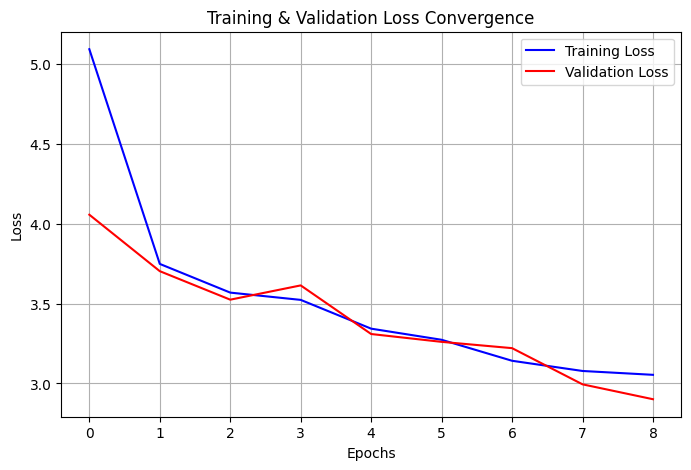

In [2]:
import matplotlib.pyplot as plt

# Compute overall training loss by summing the loss components
train_loss = df['train/box_loss'] + df['train/cls_loss'] + df['train/dfl_loss']
val_loss = df['val/box_loss'] + df['val/cls_loss'] + df['val/dfl_loss']

plt.figure(figsize=(8, 5))
plt.plot(df['epoch'], train_loss, label="Training Loss", color="blue")
plt.plot(df['epoch'], val_loss, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Convergence")
plt.legend()
plt.grid()
plt.show()

In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import random
import cv2
%matplotlib notebook
import matplotlib.pyplot as plt
from ultralytics import YOLO

model_path = "runs/detect/train5/weights/best.pt"
model = YOLO(model_path)

In [7]:
test_dir = "C:/project_ml/solar-panel-detection/dataset/split_dataset/test"
image_files = [f for f in os.listdir(test_dir) if f.lower().endswith((".jpg", ".png", ".tif"))]

# Pick 3-4 random images
random_images = random.sample(image_files, 4)
print("Random test images selected:", random_images)

Random test images selected: ['solarpanels_native_1__x0_6657_y0_12217_dxdy_416.tif', 'solarpanels_native_2__x0_8595_y0_3918_dxdy_416.tif', 'solarpanels_native_1__x0_1869_y0_7288_dxdy_416.tif', 'solarpanels_native_1__x0_1228_y0_7069_dxdy_416.tif']


In [8]:
def draw_boxes(image, boxes, color, label_type="GT"):
    """
    Draws bounding boxes on an image.
    :param image: OpenCV image array (BGR)
    :param boxes: list of bounding boxes in YOLO format or xyxy
    :param color: (B, G, R) color tuple
    :param label_type: 'GT' or 'Pred'
    """
    h, w, _ = image.shape
    for box in boxes:
        # box could be in xyxy format or YOLO format
        if len(box) == 4:
            # If it's already xyxy: x1, y1, x2, y2
            x1, y1, x2, y2 = box
        else:
            x_center, y_center, bw, bh = box[1], box[2], box[3], box[4]
            x1 = int((x_center - bw/2) * w)
            y1 = int((y_center - bh/2) * h)
            x2 = int((x_center + bw/2) * w)
            y2 = int((y_center + bh/2) * h)

        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
        # Optional: put text
        cv2.putText(image, label_type, (int(x1), int(y1) - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

Ultralytics YOLOv8.0.43  Python-3.9.18 torch-1.13.1+cpu CPU
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1__x0_6657_y0_12217_dxdy_416.tif: 640x640 41 solar_panels, 390.0ms
Speed: 0.0ms preprocess, 390.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


<IPython.core.display.Javascript object>


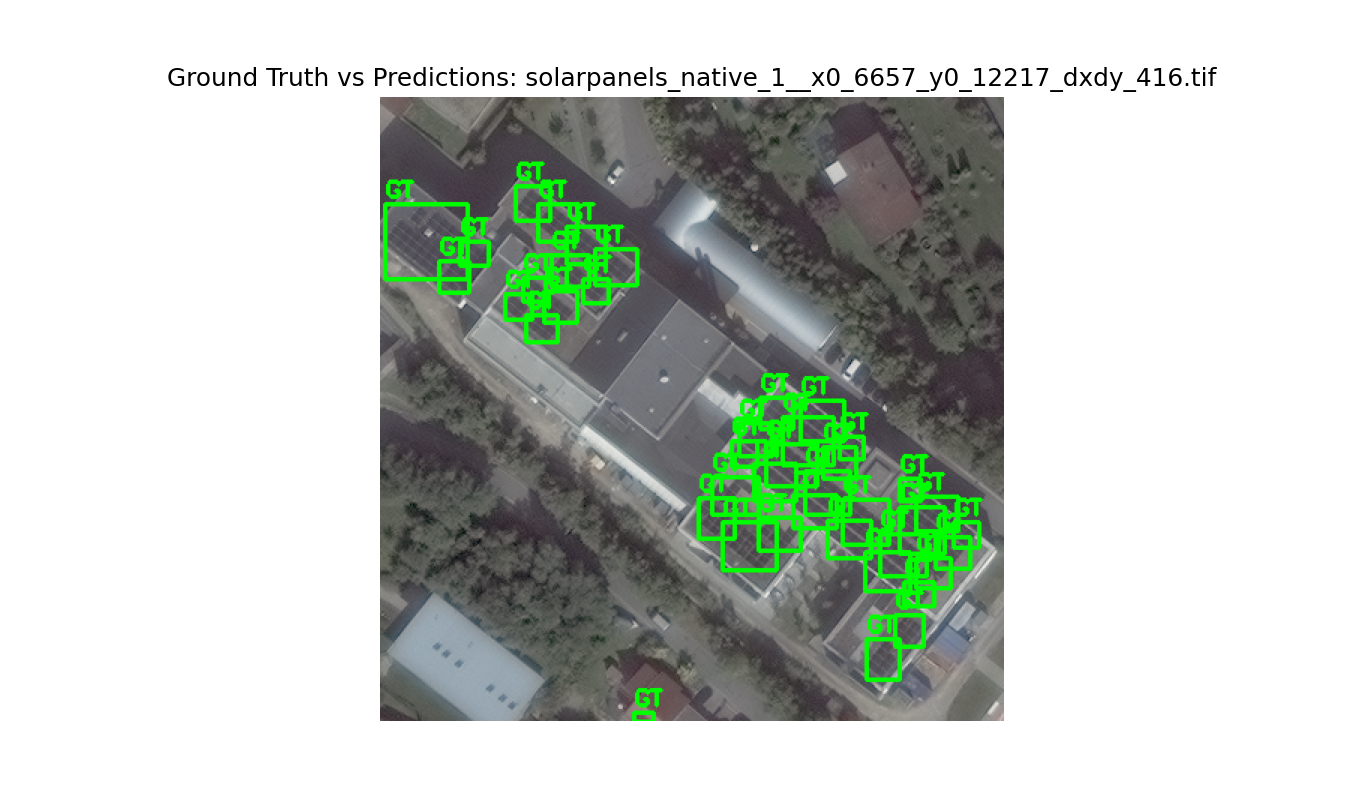

C:\Users\rucha\AppData\Local\Temp\ipykernel_18388\1247939478.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_2__x0_8595_y0_3918_dxdy_416.tif: 640x640 21 solar_panels, 423.6ms
Speed: 2.0ms preprocess, 423.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


<IPython.core.display.Javascript object>


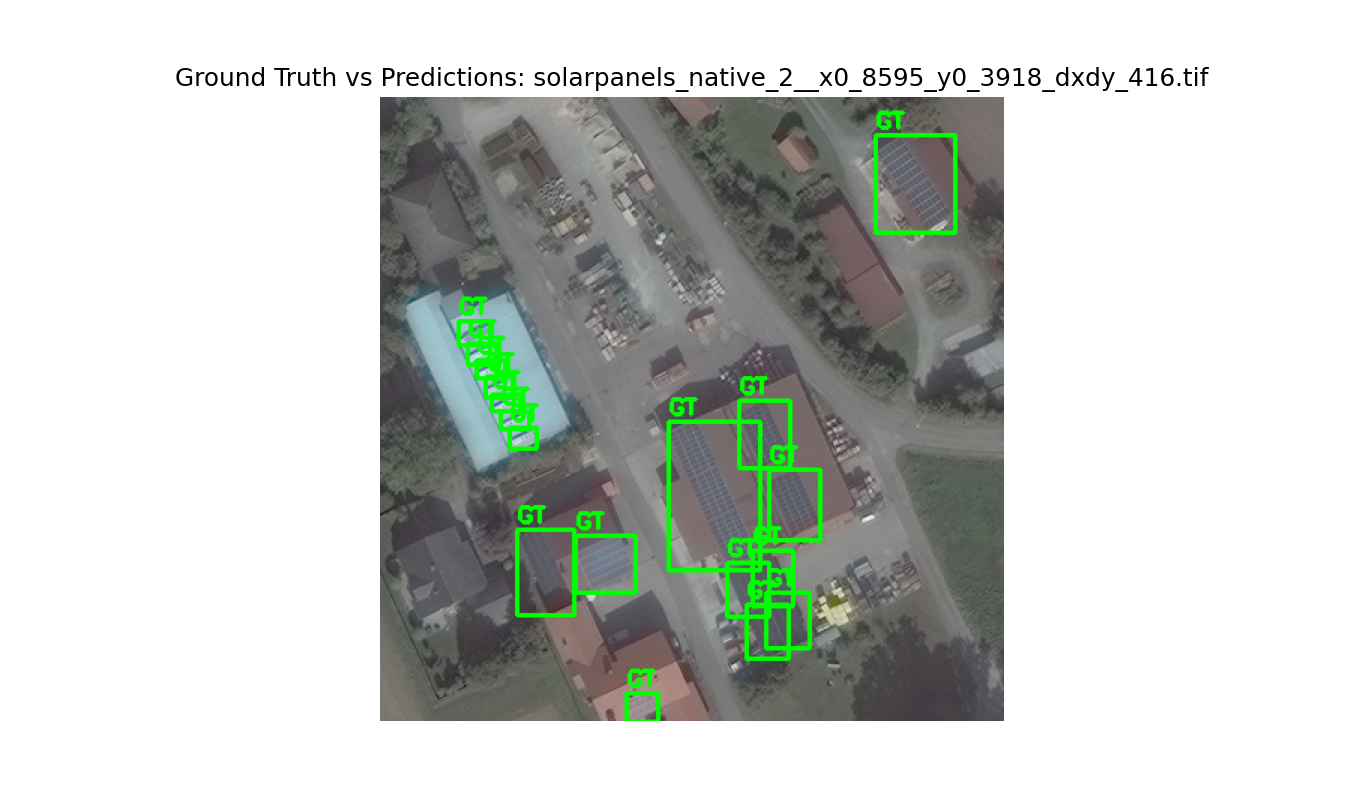


image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1__x0_1869_y0_7288_dxdy_416.tif: 640x640 6 solar_panels, 372.8ms
Speed: 6.0ms preprocess, 372.8ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)


<IPython.core.display.Javascript object>


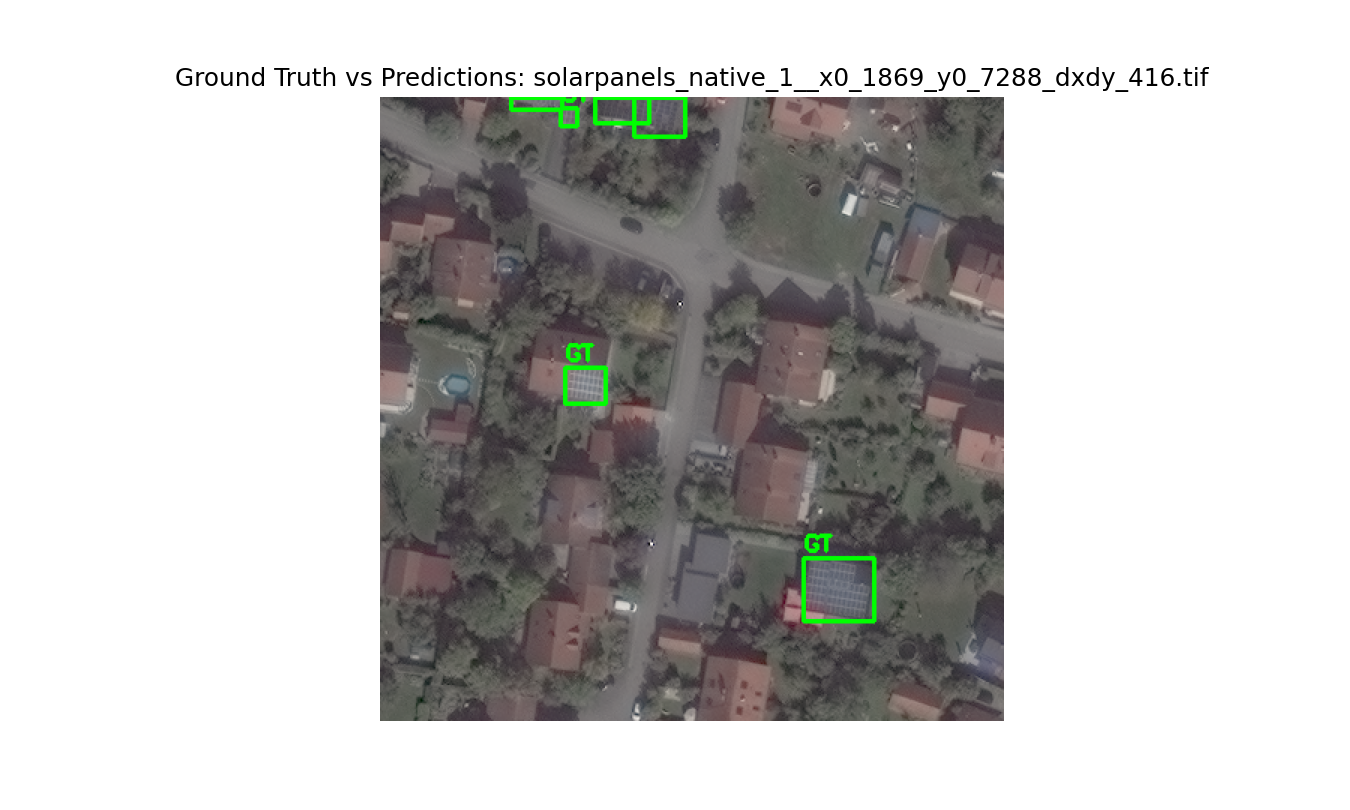


image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1__x0_1228_y0_7069_dxdy_416.tif: 640x640 6 solar_panels, 377.5ms
Speed: 3.8ms preprocess, 377.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


<IPython.core.display.Javascript object>


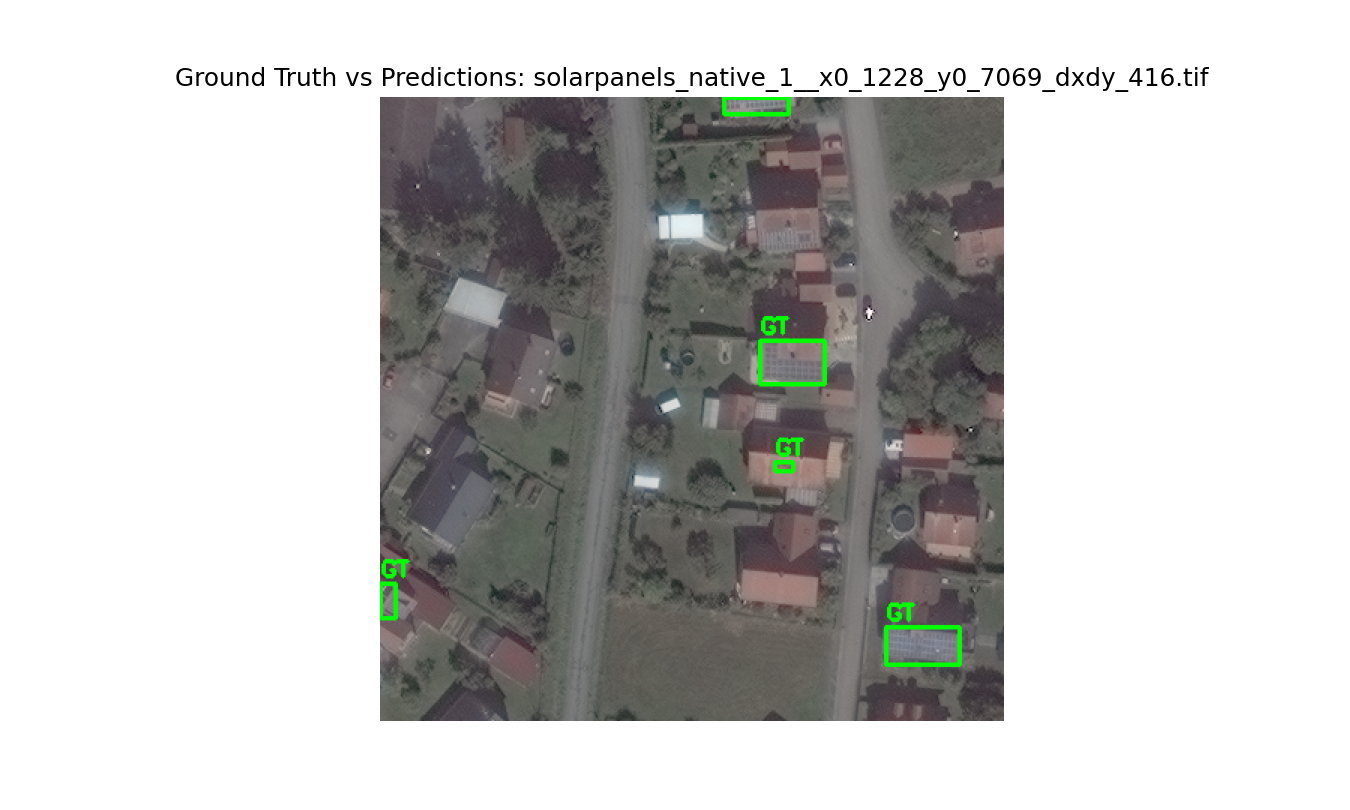

In [9]:
for img_name in random_images:
    # Paths
    img_path = os.path.join(test_dir, img_name)
    label_path = os.path.join(test_dir, img_name.rsplit('.', 1)[0] + ".txt")

    # 1. Load image with OpenCV
    image_bgr = cv2.imread(img_path)
    if image_bgr is None:
        print(f"Could not load image: {img_path}")
        continue

    # 2. Predict bounding boxes using YOLO
    results = model.predict(img_path, conf=0.3)  # Adjust conf threshold as needed

    # The predictions are in results[0].boxes
    pred_boxes = []
    for box in results[0].boxes:
        # box.xyxy -> [x1, y1, x2, y2]
        xyxy = box.xyxy[0].cpu().numpy()  # Convert to numpy
        pred_boxes.append(xyxy)

    # 3. Read the ground truth YOLO label file (if it exists)
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    # Format: class_index, x_center, y_center, width, height
                    class_index, x_center, y_center, bw, bh = map(float, parts)
                    gt_boxes.append([class_index, x_center, y_center, bw, bh])

    # 4. Draw bounding boxes
    # Draw ground truth (green)
    draw_boxes(image_bgr, gt_boxes, color=(0, 255, 0), label_type="GT")
    # Draw predictions (red)
    draw_boxes(image_bgr, [[0] + b.tolist() for b in pred_boxes], color=(0, 0, 255), label_type="Pred")

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.title(f"Ground Truth vs Predictions: {img_name}")
    plt.axis("off")
    plt.show()

In [3]:
import os

test_dir = "C:/project_ml/solar-panel-detection/dataset/split_dataset/test" 

# Supported image extensions
image_extensions = (".jpg", ".png", ".tif", ".jpeg")

# Get all image files in the test directory
image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(image_extensions)]

gt_image_label_pairs = []

for img_file in image_files:
    base_name, _ = os.path.splitext(img_file)
    label_file = base_name + ".txt"
    
    img_path = os.path.join(test_dir, img_file)
    label_path = os.path.join(test_dir, label_file)
    
    if os.path.exists(label_path):
        gt_image_label_pairs.append((img_path, label_path))
    else:
        print(f"Warning: No label file found for {img_file}")

print(f"Total test pairs found: {len(gt_image_label_pairs)}")

Total test pairs found: 382


In [9]:
import numpy as np
from supervision import Detections

def get_image_size(image_path):
    return (416, 416)

sv_ground_truths = []

for image_id, (img_path, label_path) in enumerate(gt_image_label_pairs):
    # 1. Get image size (width, height)
    img_width, img_height = get_image_size(img_path)
    
    # 2. Read YOLO labels
    with open(label_path, "r") as f:
        lines = f.readlines()
    
    boxes = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 5:
            cls_id, x_center, y_center, w, h = map(float, parts)
            
            # Convert YOLO -> xyxy
            x_min = (x_center - w/2) * img_width
            y_min = (y_center - h/2) * img_height
            x_max = (x_center + w/2) * img_width
            y_max = (y_center + h/2) * img_height
            boxes.append([x_min, y_min, x_max, y_max, cls_id])
    
    # 3. Build a Detections object
    if len(boxes) == 0:
        gt_detections = Detections.empty() 
    else:
        boxes = np.array(boxes)
        xyxy = boxes[:, :4]
        class_id = boxes[:, 4].astype(int)
        
        gt_detections = Detections(
            xyxy=xyxy,
            class_id=class_id,
            confidence=None,  
        )
    
    gt_detections_list.append(gt_detections)
    gt_detections.image_id = image_id


print(f"Created {len(gt_detections_list)} ground-truth Detections objects.")

Created 764 ground-truth Detections objects.


In [10]:
from ultralytics import YOLO

model = YOLO("runs/detect/train5/weights/best.pt")

sv_predictions = []
for image_id, (img_path, _) in enumerate(gt_image_label_pairs):
    # 1. Run inference
    results = model.predict(img_path)
    
    # 2. Extract boxes
    pred_boxes = []
    for box in results[0].boxes:
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        pred_boxes.append([x1, y1, x2, y2, cls_id, conf])
    
    if len(pred_boxes) == 0:
         gt_detections = Detections.empty()
    else:
        pred_boxes = np.array(pred_boxes)
        xyxy = pred_boxes[:, :4]
        class_id = pred_boxes[:, 4].astype(int)
        confidence = pred_boxes[:, 5]
        
        pred_det = Detections(
            xyxy=xyxy,
            class_id=class_id,
            confidence=confidence,
        )
    
    pred_detections_list.append(pred_det)
    gt_detections.image_id = image_id

print(f"Created {len(pred_detections_list)} prediction Detections objects.")

Ultralytics YOLOv8.0.43  Python-3.9.18 torch-1.13.1+cpu CPU
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1__x0_0_y0_8042_dxdy_416.tif: 640x640 6 solar_panels, 595.8ms
Speed: 7.6ms preprocess, 595.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1__x0_1001_y0_7022_dxdy_416.tif: 640x640 6 solar_panels, 448.0ms
Speed: 4.1ms preprocess, 448.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1__x0_1019_y0_7392_dxdy_416.tif: 640x640 16 solar_panels, 420.4ms
Speed: 2.8ms preprocess, 420.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1_

Speed: 0.0ms preprocess, 358.8ms inference, 15.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1__x0_2311_y0_8124_dxdy_416.tif: 640x640 9 solar_panels, 389.9ms
Speed: 0.0ms preprocess, 389.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1__x0_2353_y0_7042_dxdy_416.tif: 640x640 4 solar_panels, 377.6ms
Speed: 0.0ms preprocess, 377.6ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1__x0_2372_y0_8115_dxdy_416.tif: 640x640 10 solar_panels, 397.0ms
Speed: 4.7ms preprocess, 397.0ms inference, 8.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1__x0_23_y0_7094_dxdy_416.tif: 640x640 

Speed: 2.5ms preprocess, 407.9ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1__x0_4174_y0_13123_dxdy_416.tif: 640x640 15 solar_panels, 458.4ms
Speed: 0.0ms preprocess, 458.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1__x0_4201_y0_6566_dxdy_416.tif: 640x640 5 solar_panels, 377.6ms
Speed: 2.0ms preprocess, 377.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1__x0_4272_y0_10805_dxdy_416.tif: 640x640 3 solar_panels, 553.5ms
Speed: 0.0ms preprocess, 553.5ms inference, 9.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1__x0_4410_y0_11373_dxdy_416.tif: 640x

Speed: 0.0ms preprocess, 356.6ms inference, 13.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1__x0_7507_y0_12800_dxdy_416.tif: 640x640 6 solar_panels, 384.1ms
Speed: 0.0ms preprocess, 384.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1__x0_764_y0_7610_dxdy_416.tif: 640x640 13 solar_panels, 375.4ms
Speed: 0.0ms preprocess, 375.4ms inference, 10.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1__x0_767_y0_7450_dxdy_416.tif: 640x640 13 solar_panels, 348.9ms
Speed: 0.0ms preprocess, 348.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1__x0_7786_y0_11517_dxdy_416.tif: 640x

Speed: 0.3ms preprocess, 367.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1__x0_8965_y0_12604_dxdy_416.tif: 640x640 5 solar_panels, 364.9ms
Speed: 0.0ms preprocess, 364.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1__x0_8974_y0_12738_dxdy_416.tif: 640x640 6 solar_panels, 371.8ms
Speed: 0.0ms preprocess, 371.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1__x0_9034_y0_12029_dxdy_416.tif: 640x640 8 solar_panels, 353.4ms
Speed: 0.0ms preprocess, 353.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_1__x0_9250_y0_10525_dxdy_416.tif: 640x

Speed: 3.6ms preprocess, 366.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_2__x0_13069_y0_14531_dxdy_416.tif: 640x640 1 solar_panel, 342.5ms
Speed: 0.0ms preprocess, 342.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_2__x0_13813_y0_7121_dxdy_416.tif: 640x640 4 solar_panels, 366.1ms
Speed: 2.7ms preprocess, 366.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_2__x0_14813_y0_14131_dxdy_416.tif: 640x640 4 solar_panels, 378.2ms
Speed: 3.5ms preprocess, 378.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_2__x0_15536_y0_14453_dxdy_416.tif: 64

Speed: 0.0ms preprocess, 363.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_2__x0_527_y0_10846_dxdy_416.tif: 640x640 64 solar_panels, 688.2ms
Speed: 8.4ms preprocess, 688.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_2__x0_53_y0_11588_dxdy_416.tif: 640x640 40 solar_panels, 414.3ms
Speed: 0.0ms preprocess, 414.3ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_2__x0_5412_y0_6358_dxdy_416.tif: 640x640 1 solar_panel, 592.7ms
Speed: 8.2ms preprocess, 592.7ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_2__x0_5487_y0_5614_dxdy_416.tif: 640x640 

Speed: 8.4ms preprocess, 396.8ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_2__x0_8966_y0_4023_dxdy_416.tif: 640x640 4 solar_panels, 679.8ms
Speed: 0.0ms preprocess, 679.8ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_2__x0_8998_y0_3968_dxdy_416.tif: 640x640 4 solar_panels, 599.3ms
Speed: 8.1ms preprocess, 599.3ms inference, 8.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_2__x0_904_y0_8492_dxdy_416.tif: 640x640 7 solar_panels, 622.0ms
Speed: 2.0ms preprocess, 622.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_2__x0_9155_y0_3809_dxdy_416.tif: 640x640 7

Speed: 8.0ms preprocess, 441.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_3__x0_11042_y0_12043_dxdy_416.tif: 640x640 3 solar_panels, 423.4ms
Speed: 2.8ms preprocess, 423.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_3__x0_11123_y0_9518_dxdy_416.tif: 640x640 30 solar_panels, 466.4ms
Speed: 4.8ms preprocess, 466.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_3__x0_11165_y0_9609_dxdy_416.tif: 640x640 36 solar_panels, 381.3ms
Speed: 3.3ms preprocess, 381.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_3__x0_1124_y0_7890_dxdy_416.tif: 64

Speed: 0.0ms preprocess, 405.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_3__x0_3793_y0_15652_dxdy_416.tif: 640x640 4 solar_panels, 460.9ms
Speed: 3.8ms preprocess, 460.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_3__x0_3798_y0_8251_dxdy_416.tif: 640x640 (no detections), 346.8ms
Speed: 0.0ms preprocess, 346.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_3__x0_4324_y0_3774_dxdy_416.tif: 640x640 9 solar_panels, 372.2ms
Speed: 8.0ms preprocess, 372.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_3__x0_4471_y0_3753_dxdy_416.tif: 640x64

Speed: 5.1ms preprocess, 347.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_3__x0_6129_y0_8840_dxdy_416.tif: 640x640 3 solar_panels, 346.3ms
Speed: 3.6ms preprocess, 346.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_3__x0_6137_y0_13322_dxdy_416.tif: 640x640 10 solar_panels, 353.6ms
Speed: 2.0ms preprocess, 353.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_3__x0_6200_y0_13369_dxdy_416.tif: 640x640 9 solar_panels, 354.1ms
Speed: 0.0ms preprocess, 354.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_3__x0_6288_y0_12041_dxdy_416.tif: 640x

Speed: 0.0ms preprocess, 366.7ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_3__x0_8116_y0_9351_dxdy_416.tif: 640x640 7 solar_panels, 602.9ms
Speed: 0.0ms preprocess, 602.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_3__x0_8221_y0_10460_dxdy_416.tif: 640x640 4 solar_panels, 395.4ms
Speed: 0.0ms preprocess, 395.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_3__x0_8352_y0_11302_dxdy_416.tif: 640x640 4 solar_panels, 393.5ms
Speed: 0.0ms preprocess, 393.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\project_ml\solar-panel-detection\dataset\split_dataset\test\solarpanels_native_3__x0_8358_y0_14365_dxdy_416.tif: 640x6

Created 764 prediction Detections objects.
